# Customer Churn Prediction – Telco Dataset

This notebook builds a supervised machine learning model to predict customer churn for a telecom company. Churn prediction is important for marketing and customer retention: it helps identify which customers are likely to leave so that the company can take proactive action.

The goals of this project are:
- To explore which factors are associated with churn
- To build and evaluate classification models
- To interpret which features are most important in predicting churn

The dataset used is the public *Telco Customer Churn* dataset (IBM sample).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    classification_report,
)

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#data overview
df.shape
df.info()
df['Churn'].value_counts(normalize=True) * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

## Data Overview

Each row represents a customer. The main target variable is **Churn**, indicating whether the customer left within the last month.

Key variable groups include:
- Customer account information (tenure, contract, payment method)
- Services (phone, internet, online security, TV, etc.)
- Charges (MonthlyCharges, TotalCharges)

In [4]:
#convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#check missing values
df.isna().sum()

#drop rows with missing TotalCharges
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

df.isna().sum

<bound method DataFrame.sum of       customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0          False   False          False    False       False   False   
1          False   False          False    False       False   False   
2          False   False          False    False       False   False   
3          False   False          False    False       False   False   
4          False   False          False    False       False   False   
...          ...     ...            ...      ...         ...     ...   
7027       False   False          False    False       False   False   
7028       False   False          False    False       False   False   
7029       False   False          False    False       False   False   
7030       False   False          False    False       False   False   
7031       False   False          False    False       False   False   

      PhoneService  MultipleLines  InternetService  OnlineSecurity  \
0            False          False 

In [5]:
df['Churn'].value_counts()

#encode target: Yes = 1, No = 0
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
df['Churn'].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

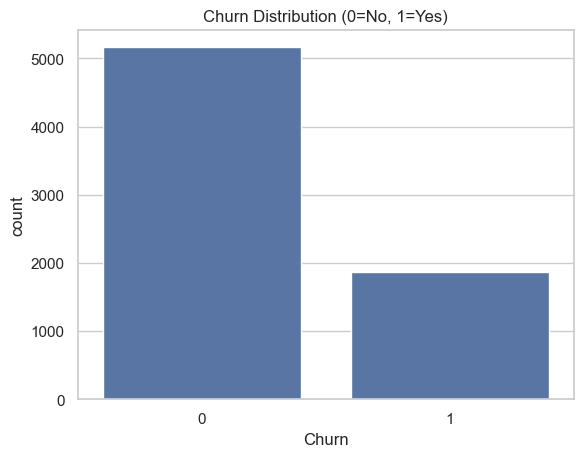

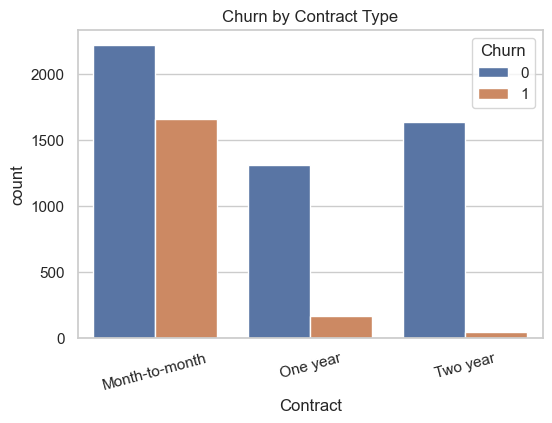

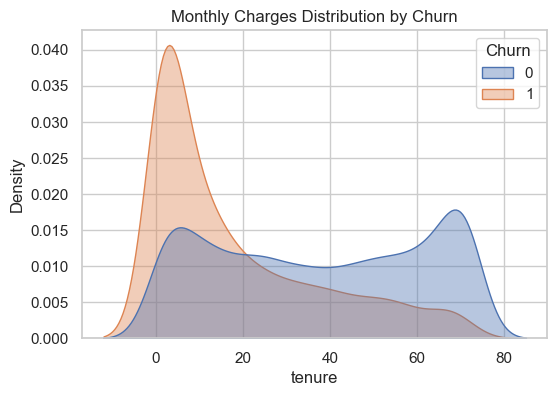

In [9]:
#churn distribution
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution (0=No, 1=Yes)')
plt.show()

#churn by contract type
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn by Contract Type')
plt.xticks(rotation=15)
plt.show()

#tenure distribution by churn
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False, alpha=0.4)
plt.title('Monthly Charges Distribution by Churn')
plt.show()

In [10]:
#drop ID column
df = df.drop(columns=['customerID'])

target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [11]:
#train/test sets split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((5625, 19), (1407, 19))

In [13]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

numeric_features, categorical_features

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

In [14]:
#preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

In [15]:
#logistic regression pipeline
log_reg_clf = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(max_iter=1000)),
    ]
)

log_reg_clf

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
#fit logistic regression
log_reg_clf.fit(X_train, y_train)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
#evaluation helper
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name='Model'):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_test_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

    print(f'{model_name}')
    print('Train accuracy:', accuracy_score(y_train, y_train_pred))
    print('Test accuracy:', accuracy_score(y_test, y_test_pred))
    print('Test precision:', precision_score(y_test, y_test_pred))
    print('Test recall:', recall_score(y_test, y_test_pred))
    print('Test F1-score:', f1_score(y_test, y_test_pred))

    if y_test_proba is not None:
        print('Test ROC AUC :', roc_auc_score(y_test, y_test_proba))
    
    print('\nClassification report (test set):')
    print(classification_report(y_test, y_test_pred))

    #confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    #ROC curve
    if y_test_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_test_proba)
        plt.title(f'ROC Curve - {model_name}')
        plt.show()

Logistic Regression
Train accuracy: 0.8042666666666667
Test accuracy: 0.8024164889836531
Test precision: 0.6437125748502994
Test recall: 0.5748663101604278
Test F1-score: 0.6073446327683616
Test ROC AUC : 0.8365399050582126

Classification report (test set):
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1033
           1       0.64      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



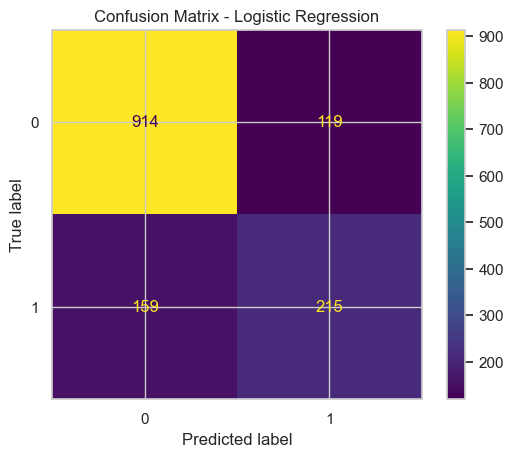

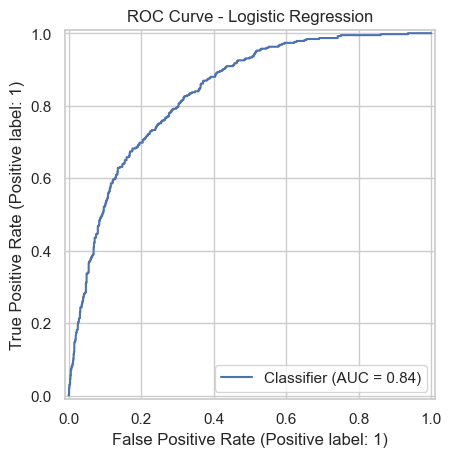

In [20]:
#evaluate logistic regression
evaluate_classifier(
    log_reg_clf,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name='Logistic Regression'
)

In [21]:
#random forest pipeline
rf_clf = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

rf_clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Random Forest
Train accuracy: 0.9329777777777778
Test accuracy: 0.7903340440653873
Test precision: 0.6295081967213115
Test recall: 0.5133689839572193
Test F1-score: 0.5655375552282769
Test ROC AUC : 0.8273511551941026

Classification report (test set):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.51      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



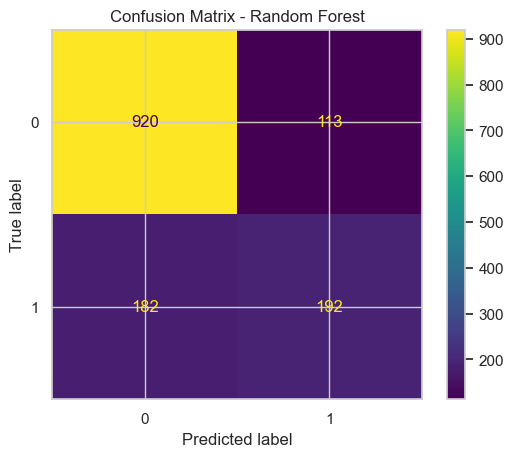

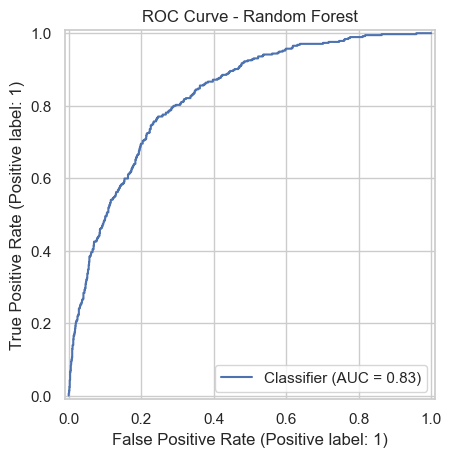

In [22]:
#evaluate random forest
evaluate_classifier(
    rf_clf,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name='Random Forest'
)

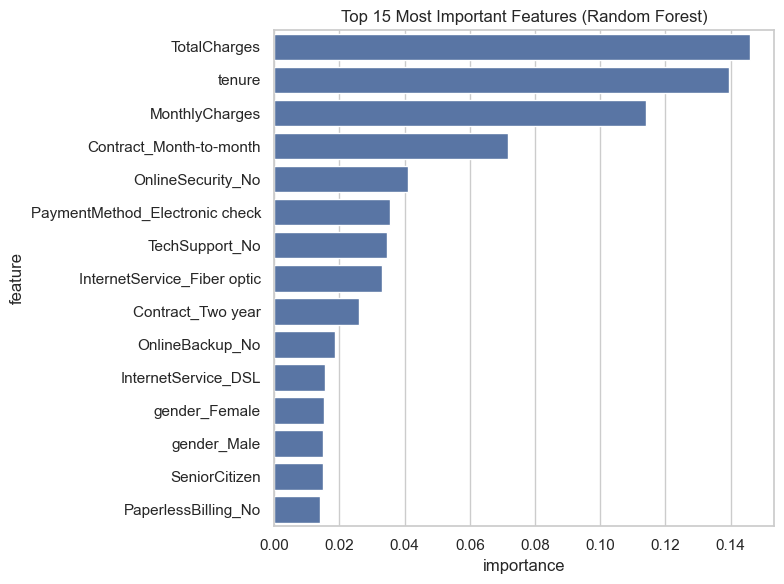

In [23]:
# Extract trained RandomForest model (inside the pipeline)
rf_model = rf_clf.named_steps['model']

# Get feature names after preprocessing
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = list(ohe_feature_names) + numeric_features

len(all_feature_names), rf_model.feature_importances_.shape

# Build a DataFrame of feature importances
fi = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_,
})

fi_sorted = fi.sort_values('importance', ascending=False)

fi_sorted.head(15)

# Plot top 15 important features
plt.figure(figsize=(8, 6))
sns.barplot(data=fi_sorted.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

## Conclusions

- Both Logistic Regression and Random Forest are able to predict churn with reasonable performance.
- Random Forest generally achieves higher recall and ROC AUC, indicating better ability to detect customers who are likely to churn.
- Important drivers of churn include contract type, tenure, monthly charges, and related service features.
- From a business perspective, customers on month-to-month contracts with higher monthly charges and shorter tenure appear more likely to churn, suggesting that longer-term contracts or targeted retention offers may help reduce churn.